In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-24_22-00-20_192734_run_000000111/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-24_22-00-20_192734_run_000000111 
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-24_22-00-20_192734_run_000000114/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-24_22-00-20_192734_run_000000114 
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-24_22-00-20_192734_run_000000055/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_loc

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    4803

## Run Parameters

    amcl_alpha_factor                                                      [nan, 0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl', 'localization_generator']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

## Metrics

    average_rotation_velocity                                              min:  0.0006123             avg:     0.1579             max:     0.6923             nan:       1616

    average_translation_velocity                                           min:  0.0007739             avg:     0.2175             max:     0.3032             nan:       1616

    collision_rate                                                         min:          0             avg:    0.09869             max:          1             nan:          0

<code><font style='background-color:yellow;font-family:monospace'>collision_rate_version                                                [1, 2] </font></code> ⚠️

    controller_cpu_time                                                    min:       0.53             avg:      84.06             max:      848.9             nan:          0

    controller_max_memory                                                  min:      21.35             avg:      51.77             max:      78.79             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      0.078             avg:      80.15             max:        627             nan:          0

    execution_time_version                                                 [1]

    absolute_rotation_error                                                min:  3.887e-07             avg:    0.03126             max:      1.831             nan:        745

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04918             max:      1.348             nan:        745

    absolute_translation_error                                             min:   0.003454             avg:    0.09853             max:      3.029             nan:        745

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.03875             max:      3.775             nan:        745

    localization_update_error_version                                      [1]

    normalized_relative_rotation_error                                     min:   0.001355             avg:     0.2344             max:      12.29             nan:        761

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:      1.038             max:      43.93             nan:        761

    normalized_relative_translation_error                                  min:    0.00843             avg:    0.07574             max:      3.082             nan:        760

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.08526             max:      9.121             nan:        760

    localization_update_rate                                               min:    0.09353             avg:     0.9719             max:       32.4             nan:        738

    localization_update_rate_std                                           min:          0             avg:     0.3486             max:      14.34             nan:        738

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:  2.441e-07             avg:    0.01638             max:     0.8108             nan:        745

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.04675             max:     0.8738             nan:        745

    localization_update_relative_translation_error_mean                    min:  1.036e-05             avg:     0.0139             max:     0.5565             nan:        745

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01336             max:      1.529             nan:        745

<code><font style='background-color:yellow;font-family:monospace'>motion_characteristics_version                                        [nan, 1.0] </font></code> ⚠️

    odometry_error_alpha_1_mean                                            min:  1.143e-17             avg:    0.09574             max:      11.76             nan:        755

    odometry_error_alpha_1_std                                             min:          0             avg:     0.2111             max:      44.74             nan:        755

    odometry_error_alpha_2_mean                                            min:  1.522e-18             avg:     0.1317             max:      9.943             nan:        755

    odometry_error_alpha_2_std                                             min:          0             avg:     0.3017             max:      33.96             nan:        755

    odometry_error_alpha_3_mean                                            min:  3.373e-17             avg:    0.06901             max:     0.8971             nan:        755

    odometry_error_alpha_3_std                                             min:          0             avg:    0.02618             max:      1.184             nan:        755

    odometry_error_alpha_4_mean                                            min:  2.374e-17             avg:     0.2634             max:      1.401             nan:        755

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2364             max:      1.326             nan:        755

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.32             avg:      26.27             max:        395             nan:          0

    planner_max_memory                                                     min:      22.38             avg:      676.8             max:  3.116e+04             nan:          0

    success_rate                                                           min:          0             avg:     0.6917             max:          1             nan:          0

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:          3             avg:        123             max:       1005             nan:          0

    system_max_memory                                                      min:      132.3             avg:      849.6             max:  3.134e+04             nan:          0

    trajectory_length                                                      min:          0             avg:       18.1             max:      128.6             nan:          0

    trajectory_length_version                                              [1]

    average_velocity                                                       min:          0             avg:     0.1872             max:     0.2681             nan:          0

    collisionless_success_rate                                             min:          0             avg:     0.6458             max:          1             nan:          0

In [6]:
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir):
    max_y = -np.inf

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():


            for local_planner_node in df.local_planner_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max(), bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node}, {localization_node.replace("localization_generator", "gen")}', linewidth=2 if g else 1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node}, {localization_node.replace("localization_generator", "gen")}', linewidth=2 if g else 1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())
                    
#                     plt.scatter(df_lr[input_metric.name], df_lr[output_metric.name], color=local_planner_color[local_planner_node], marker='x', linewidth=0.5)
#                     max_y = max(max_y, df_lr[output_metric.name].max())

            g = localization_node == 'localization_generator'
            df_lr = selected_df[
                (selected_df.localization_node == localization_node) & 
                selected_df[input_metric.name].notna() & 
                selected_df[output_metric.name].notna()
            ].copy()
            if len(df_lr[input_metric.name]):
                if bin_width is not None:
                    if isinstance(bin_width, str):
                        _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                    else:
                        bins = np.arange(0., input_metric.max(), bin_width)

                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                    df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                    plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'all, {localization_node.replace("localization_generator", "gen")}', linewidth=3 if g else 2, color="black")
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                    df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                    plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'all, {localization_node.replace("localization_generator", "gen")}', linewidth=3 if g else 2, color="black")
                max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([0, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


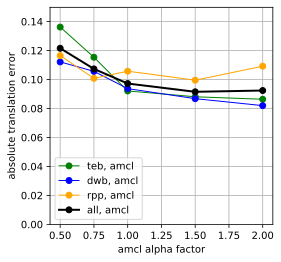

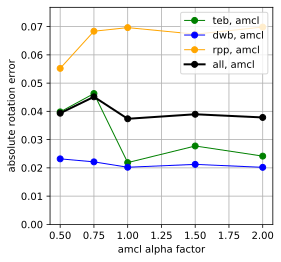

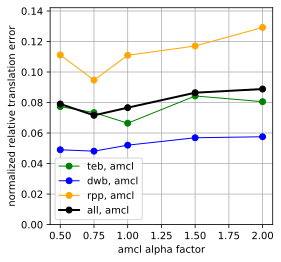

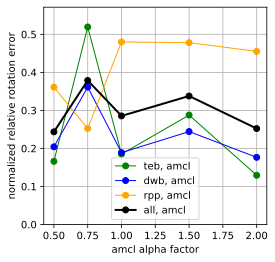

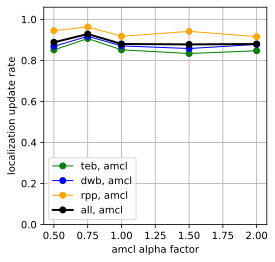

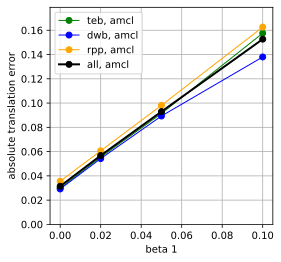

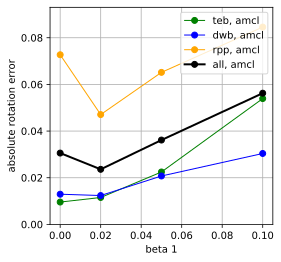

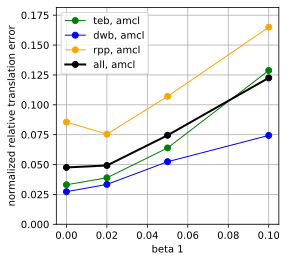

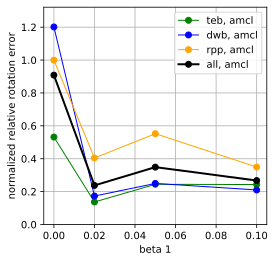

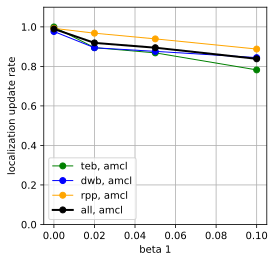

In [7]:
## plots_localization amcl_alpha_factor

min_bin_count = 10

# df_localization_plots_aaf = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
df_localization_plots_aaf = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.localization_update_rate, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_all_runs",
)

## plots_localization beta_1

df_localization_plots_beta = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.localization_update_rate, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_all_runs",
)

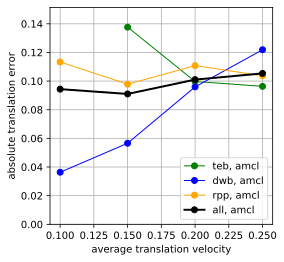

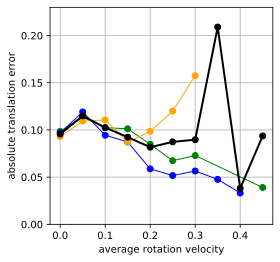

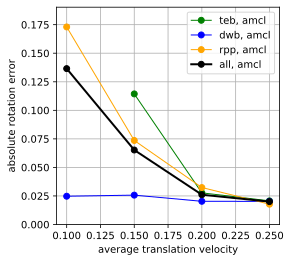

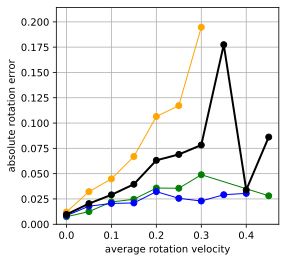

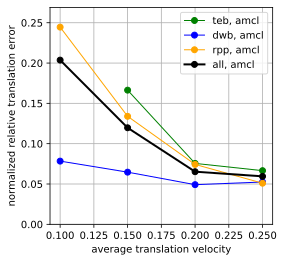

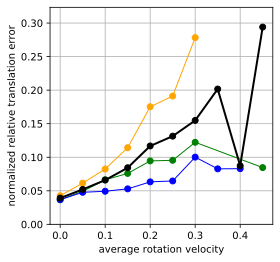

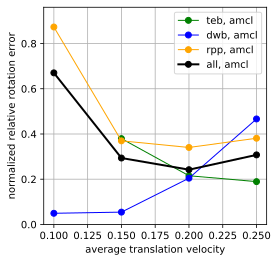

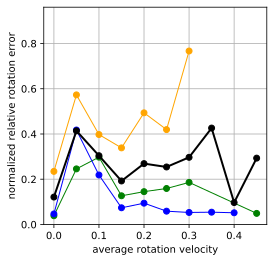

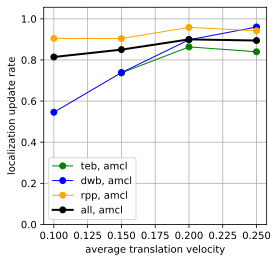

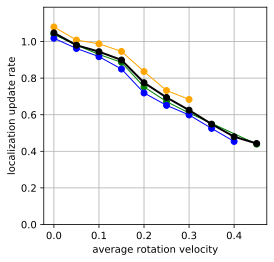

In [8]:
## plots_localization average_rotation_velocity average_translation_velocity

df_localization_plots_rot = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.absolute_translation_error, 
    input_metrics=[df_localization_plots_rot.average_translation_velocity, df_localization_plots_rot.average_rotation_velocity], 
    bin_widths=[0.05, 0.05],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.absolute_rotation_error, 
    input_metrics=[df_localization_plots_rot.average_translation_velocity, df_localization_plots_rot.average_rotation_velocity], 
    bin_widths=[0.05, 0.05],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_rot.average_translation_velocity, df_localization_plots_rot.average_rotation_velocity], 
    bin_widths=[0.05, 0.05],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_rot.average_translation_velocity, df_localization_plots_rot.average_rotation_velocity], 
    bin_widths=[0.05, 0.05],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots/localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.localization_update_rate, 
    input_metrics=[df_localization_plots_rot.average_translation_velocity, df_localization_plots_rot.average_rotation_velocity], 
    bin_widths=[0.05, 0.05],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots/localization_all_runs",
)

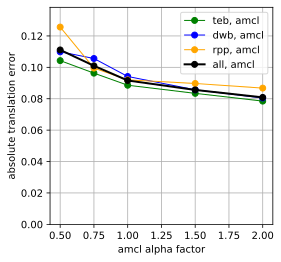

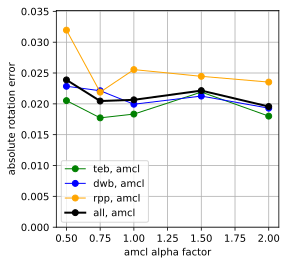

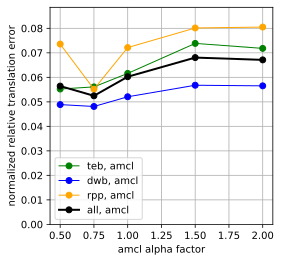

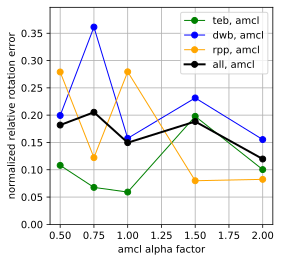

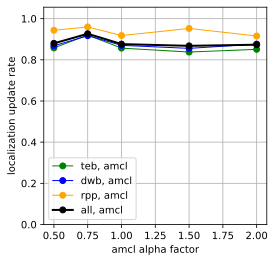

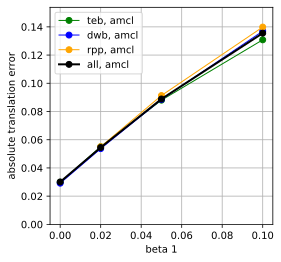

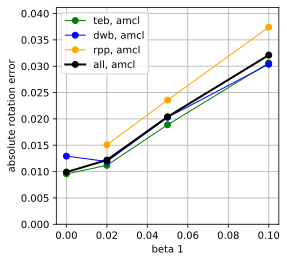

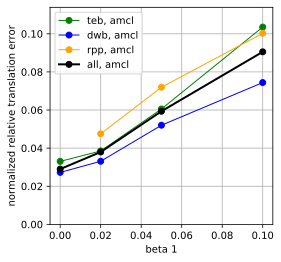

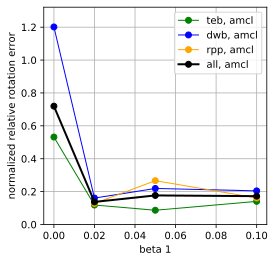

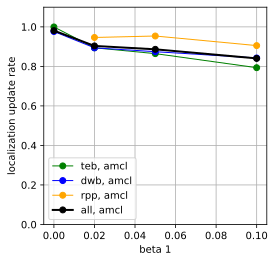

In [9]:
## plots_localization amcl_alpha_factor

min_bin_count = 10

df_localization_plots_aaf = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.localization_update_rate, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots/localization_only_successful_nav",
)

## plots_localization beta_1

df_localization_plots_beta = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.localization_update_rate, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots/localization_only_successful_nav",
)

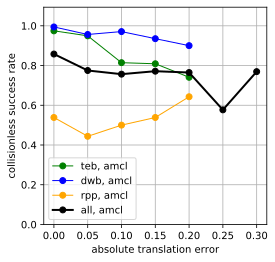

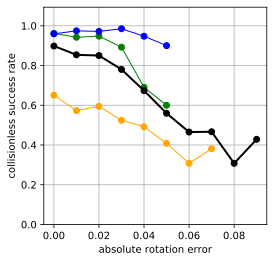

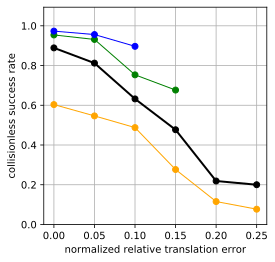

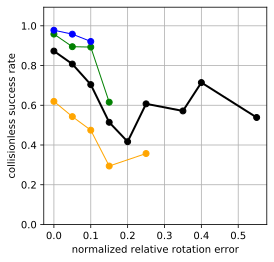

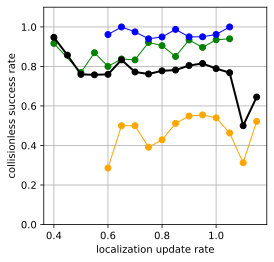

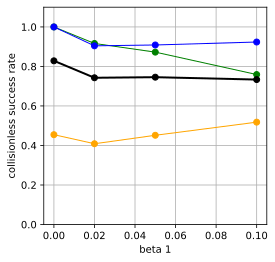

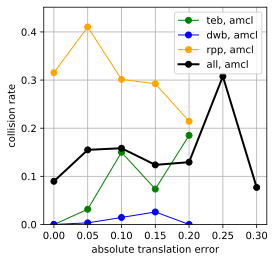

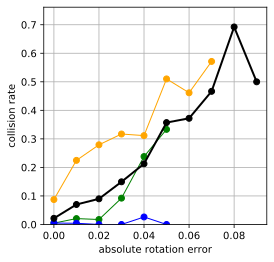

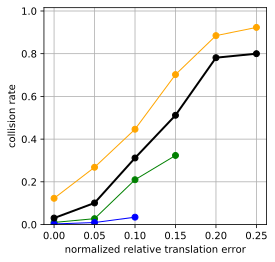

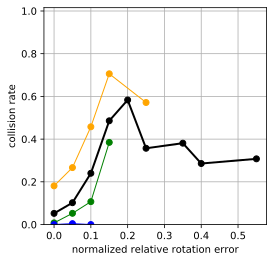

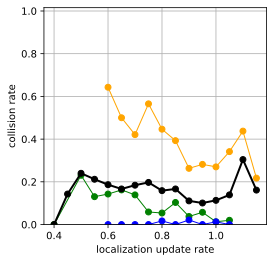

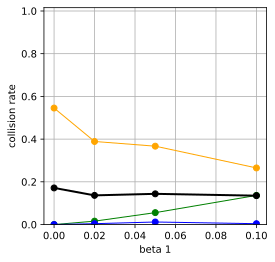

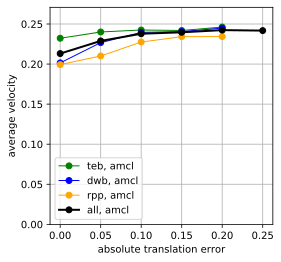

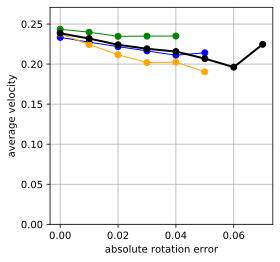

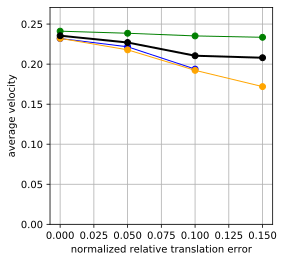

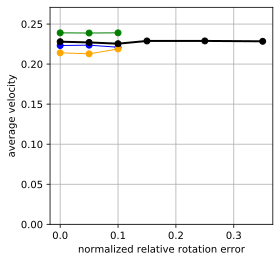

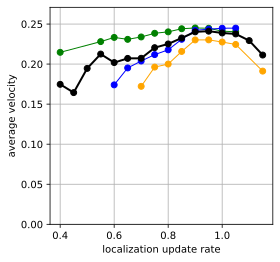

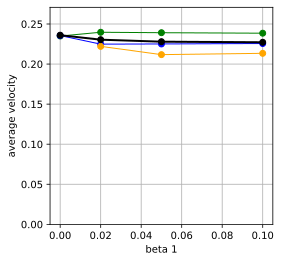

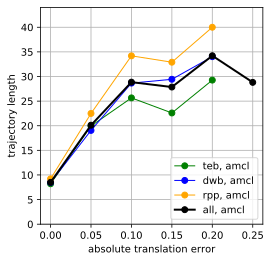

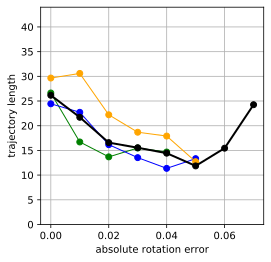

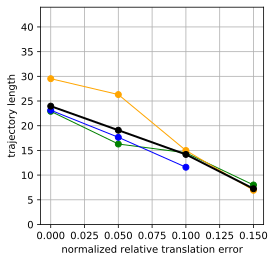

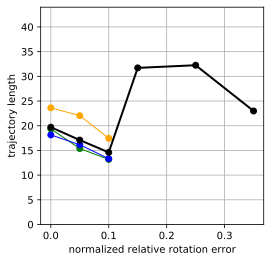

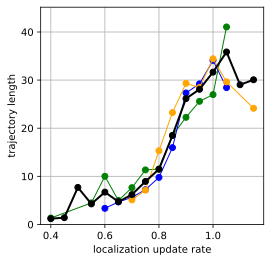

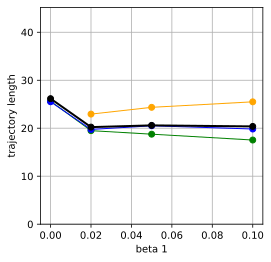

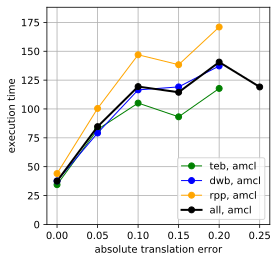

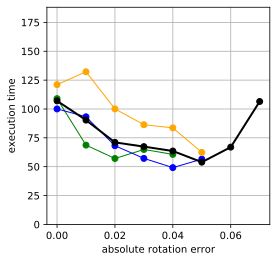

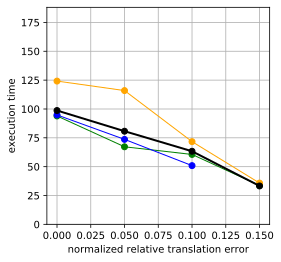

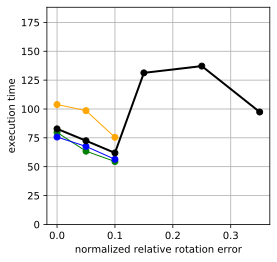

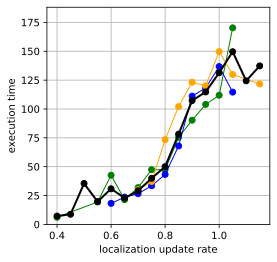

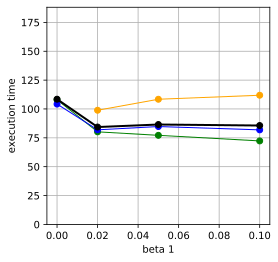

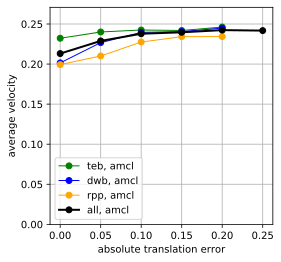

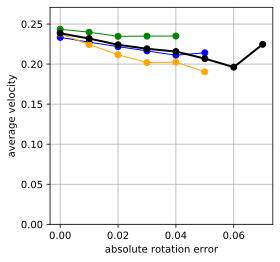

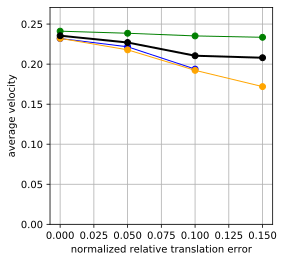

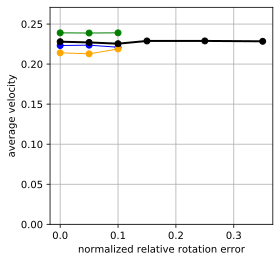

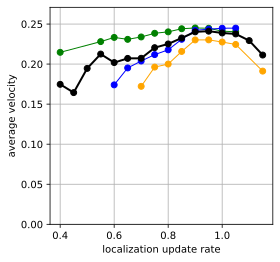

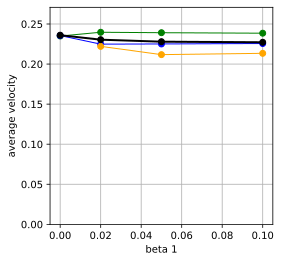

In [10]:
## plots_local_planner

min_bin_count = 10
bin_widths = [0.05, 0.01, 0.05, 0.05, 0.05, None]

df_lp = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp.collisionless_success_rate, 
    input_metrics=[df_lp.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp,
    out_dir="plots/local_planner",
)

df_lp = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp.collision_rate, 
    input_metrics=[df_lp.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp,
    out_dir="plots/local_planner",
)

df_lp_s = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp_s.average_velocity, 
    input_metrics=[df_lp_s.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp_s,
    out_dir="plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp_s.trajectory_length, 
    input_metrics=[df_lp_s.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp_s,
    out_dir="plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp_s.execution_time, 
    input_metrics=[df_lp_s.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp_s,
    out_dir="plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_lp_s.average_velocity, 
    input_metrics=[df_lp_s.absolute_translation_error, df_lp.absolute_rotation_error, df_lp.normalized_relative_translation_error, df_lp.normalized_relative_rotation_error, df_lp.localization_update_rate, df_lp.beta_1], 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=df_lp_s,
    out_dir="plots/local_planner",
)


In [11]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["collisionless_success_rate", "collision_rate", "average_velocity", "execution_time", "trajectory_length", ]].agg(['mean', 'count']).sort_values(('collisionless_success_rate', 'mean'), ascending=False)

collisionless_success_rate       collision_rate       average_velocity       execution_time       trajectory_length      
                                                                                                   mean count           mean count             mean count           mean count              mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                               
turtle      dwb                90.000                 amcl                                        0.914   764          0.007   764            0.215   764         79.826   764            19.319   764
                                                      localization_generator                      0.872   148          0.007   148            0.220   148         85.965   148            20.951   148
            teb                40.000                 amcl                                        0.789   375          0.101   375            0.218   375        101.375   375            22.638   375
                               90.000                 localization_generator                      0.768   181          0.066   181            0.226   181         72.992   181            17.722   181
                               40.000                 localization_generator                      0.702   282          0.089   282            0.209   282         89.995   282            20.493   282
                               20.000                 amcl                                        0.658   383          0.078   383            0.199   383        118.257   383            24.646   383
                                                      localization_generator                      0.592   277          0.069   277            0.191   277        100.565   277            20.950   277
            rpp                90.000                 localization_generator                      0.550   109          0.284   109            0.211   109        119.072   109            26.838   109
            teb                90.000                 amcl                                        0.536  1524          0.034  1524            0.145  1524         43.091  1524            10.307  1524
            rpp                90.000                 amcl                                        0.459   760          0.343   760            0.194   760        108.982   760            23.341   760

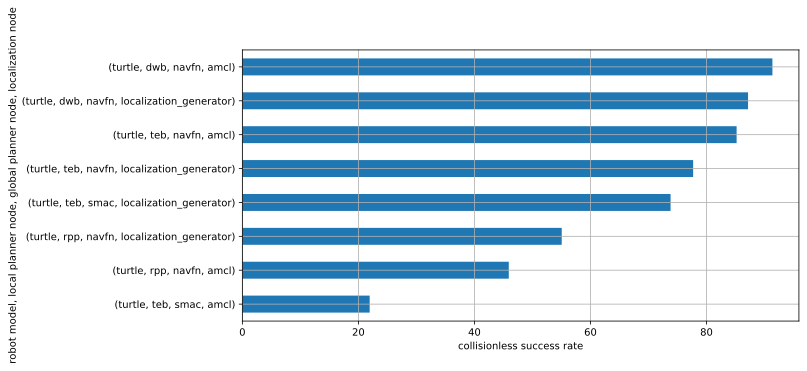

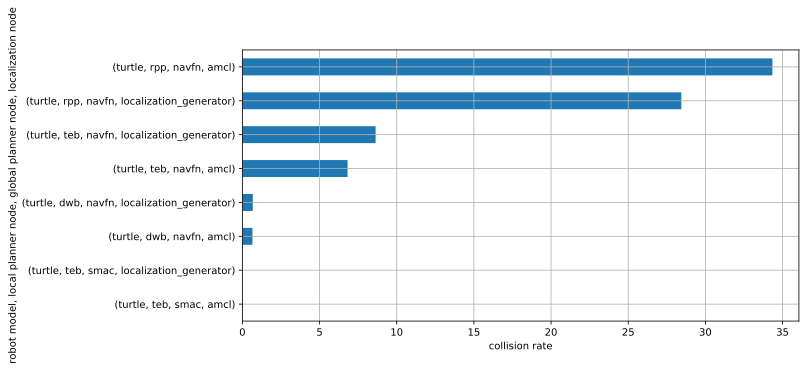

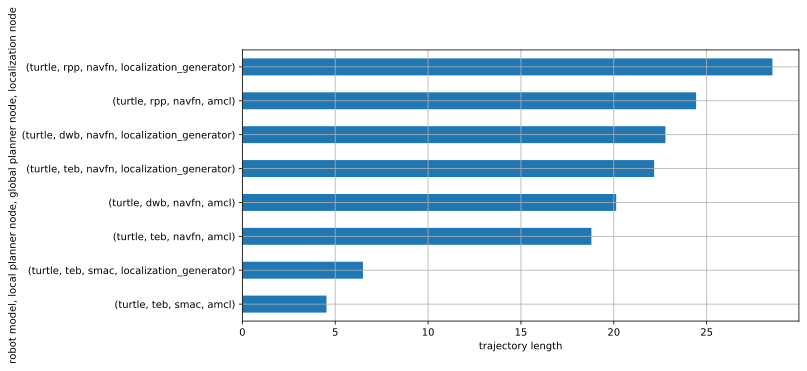

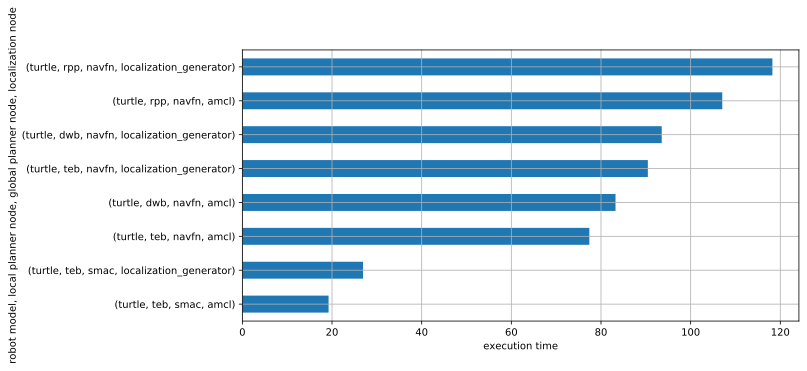

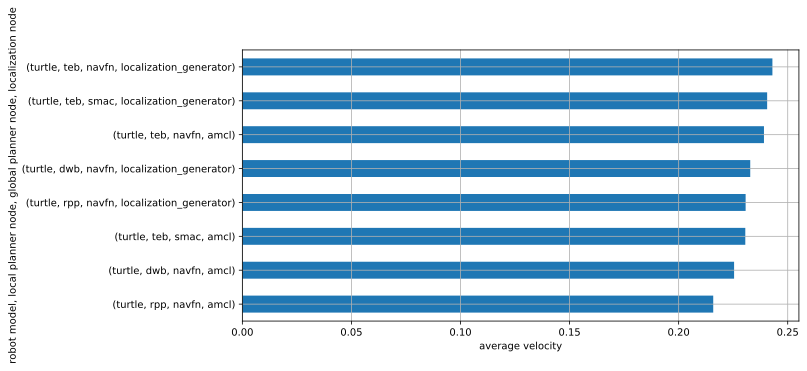

In [12]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
    ax = (bar_df.sort_values(by=('mean'), ascending=True)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', '))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
    plt.show()

bar_plot(metric_name='collisionless_success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)
bar_plot(metric_name='trajectory_length', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])
bar_plot(metric_name='execution_time', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])
bar_plot(metric_name='average_velocity', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])